In [35]:
import os
import pandas
from tabulate import tabulate
#去powershell download

In [36]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import networkx

In [37]:
#from GameHistory import GameHistory

In [38]:
class GameHistory():
    def __init__(self, game_dimension=(19, 19), game_players=6, game_members=8):
        self.game_history_folder = 'C:\\Users\\user\\anaconda3\\Projects\\BizCases\\SurvivalGame'
        self.game_dimension = game_dimension
        self.game_players = 6
        self.game_members = 8
        self.game_history = None

    def get_game_history(self):
        game_history_csv = '%s/GameHistory/GAME-%d-%d.csv' % (
            self.game_history_folder, self.game_players, self.game_members)

        if not os.path.exists(game_history_csv):
            print('%s 檔案不存在' % game_history_csv)
            self.game_history = None
            return None

        self.game_history = pandas.read_csv(game_history_csv, header=0, encoding='utf8')
        self.game_history.sort_values(by=['epoch', 'player'], inplace=True)

        return self.game_history
    
    def game_history_exists(self):
        return self.game_history is not None
    
    def get_game_last_epoch(self):
        _last_epoch = -1
        
        if self.game_history_exists():
            _last_epoch = self.game_history['epoch'].unique().max()
            
        return _last_epoch
    
    def get_game_epoch(self, my_game_epoch=0):
        return self.game_history.loc[self.game_history['epoch'] == my_game_epoch].copy()
    
    def get_game_survivor_left(self, my_game_survivor_left=1):
        _game_epochs = sorted(self.game_history['epoch'].unique())
        
        for _game_epoch in _game_epochs:
            _survivor_left_epoch = self.game_history.loc[self.game_history['epoch'] == _game_epoch].copy()
            _survivor_left = _survivor_left_epoch.groupby(['player']).agg('count')
                   
            if _survivor_left.shape[0] == my_game_survivor_left:
                return self.game_history.loc[self.game_history['epoch'] == _game_epoch]
            
        return None
    
    def output_game_history(self, my_game_history):
        if my_game_history.empty:
            return
        
        print(tabulate(my_game_history[['epoch', 'player', 'x', 'y', 'weight']], 
               headers=['世代', '玩家', '座標-X', '座標-Y', '權重'], showindex=False))


In [39]:
t=GameHistory()
t.get_game_history()
#t.get_game_last_epoch()
subset = t.get_game_epoch(369).sort_values(by=['player']) #將特定世代存入dataframe
players = sorted(subset['player'].unique())
subset

,epoch,player,member,x,y,dir,weight
2845,369,俄,0,3,13,3,6
2843,369,法,0,0,15,7,2
2844,369,法,2,16,6,7,2


In [40]:
t.get_game_survivor_left(2)

,epoch,player,member,x,y,dir,weight
2409,232,俄,0,1,10,0,6
2410,232,俄,2,9,2,2,1
2407,232,法,0,10,1,4,2
2408,232,法,2,16,4,4,2


1.建構類別,繼承GameHistory基底類別
<br>2.建構某世代遊戲紀錄之途徑資料物件
<br>3.建構不同遊戲生存玩家數之途徑資料字典物件
<br>4.輸出遊戲紀錄途徑之詳細資料
<br>5.取得某世代遊戲紀錄途徑之權重字典資料
<br>6.依照某世代遊戲紀錄途徑權重,衍生新遊戲紀錄途徑
<br>7.繪製某世代遊戲紀錄途徑權重圖

In [41]:
class PlotGameNeowrks(GameHistory):
    def __init__(self, game_dimension=(19, 19), game_players=6, game_members=8):
        GameHistory.__init__(self, game_dimension, game_players, game_members)
        self.plot_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=10)    
        
    #以世代為中心,將player及其memeber畫圖
    def get_epoch_graph(self, my_game_epoch=0):
        _subset = self.get_game_epoch(my_game_epoch).sort_values(by=['player']) #將特定世代存入dataframe
        #從dataframe中分別儲存player和member
        _players = sorted(_subset['player'].unique())
        _members = sorted(_subset['member'].unique())

        G = networkx.Graph() #繪圖
        #加入點和邊的內容
        for player in _players:
            G.add_edge('Epoch-%d' % my_game_epoch, player) #建立中心節點連結player

            for member in _members:
                _node_id = '%s-%d' % (player, member) #定義node的id
                _subset2 = _subset.loc[(_subset['player'] == player) & (_subset['member'] == member)] #當前的player及其memeber
                
                G.add_edge(player, _node_id)#將player和其member連接

                networkx.set_node_attributes(G, { #加入node資訊和權重
                    _node_id: {'x': _subset2['x'].values, 
                               'y': _subset2['y'].values, 
                               'weight': _subset2['weight'].values}
                })

        return G   
    
    def get_survivor_left_by_graph(self):
        game_networks = dict() #jason
        
        for epoch in sorted(self.game_history['epoch'].unique()): #各個epoch
            _G = self.get_epoch_graph(epoch) #特定epoch的圖

            for node_id, num_of_edges in _G.degree(): #特定世代中的邊數量(用來計算存活數量)
                if node_id == 'Epoch-%d' % (epoch):
                    if num_of_edges not in game_networks: #若沒有存入過
                        game_networks[num_of_edges] = [epoch, _G] #依存活數量做分類,存入世代[0]和圖[1]->[[存活數量][世代,圖]]

        return game_networks
    
    def get_game_history_by_grpah(self, game_epoch_networks): #(陣列)
        for node in game_epoch_networks[1].nodes(data=True): #[1]得到[epoch,_G]
            if 'weight' in node[1]: #node[1]為G,node[0]為epoch
                if len(node[1]['weight']) > 0:
                    print('%s (%2d, %2d): %d' % (node[0], node[1]['x'], node[1]['y'], node[1]['weight']))
                    
    def plot_graph(self, game_graph):
        fig, ax = plt.subplots(dpi=120, figsize=(8, 8))
        networkx.draw(game_graph, ax=ax,
                      font_family=[self.plot_font.get_name()], 
                      with_labels=True)
        plt.show()

   0	6
  40	4
  84	3
 232	2
 539	1


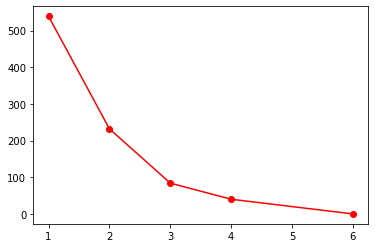

In [42]:
if __name__ == '__main__':
    worker = PlotGameNeowrks(game_dimension=(19, 19),
                             game_players=6,
                             game_members=8)
    
    game_history = worker.get_game_history()   
    game_networks = worker.get_survivor_left_by_graph()
    
    a=[]
    b=[]
    for survivor_left in game_networks:
        survivor_info = game_networks[survivor_left]      
        print('%4d\t%d' % (survivor_info[0], survivor_left))
        a.append(survivor_left)
        b.append(survivor_info[0])
    plt.plot(a,b,'o-',color='r')
    plt.show() 

In [43]:
g=t.get_game_epoch(my_game_epoch=game_networks[3][0])
g['weight']

1454    6
1455    1
1456    1
1457    1
1458    1
1459    1
1452    2
1453    2
Name: weight, dtype: int64

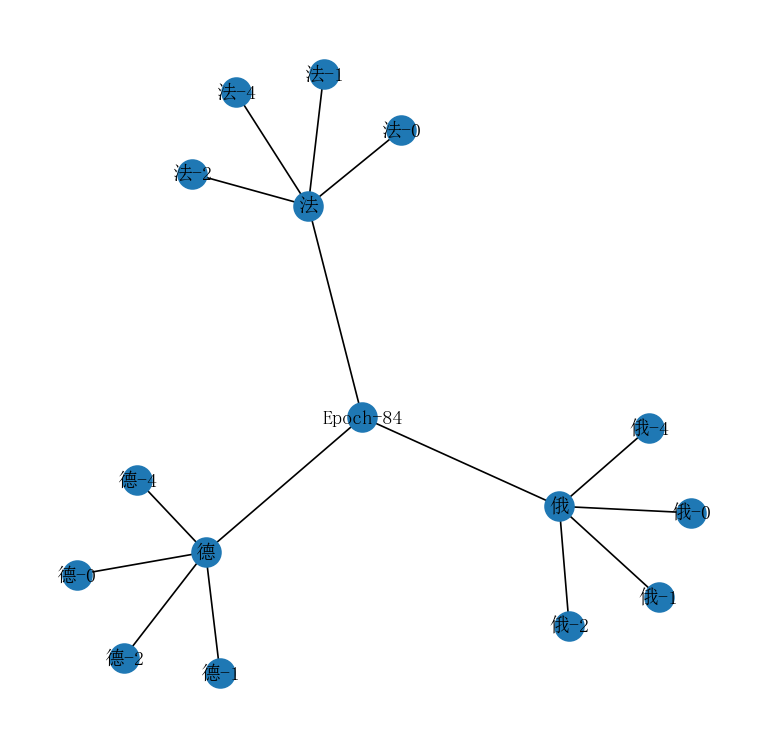

In [44]:
worker.plot_graph(game_networks[3][1]) #剩下三個player的圖

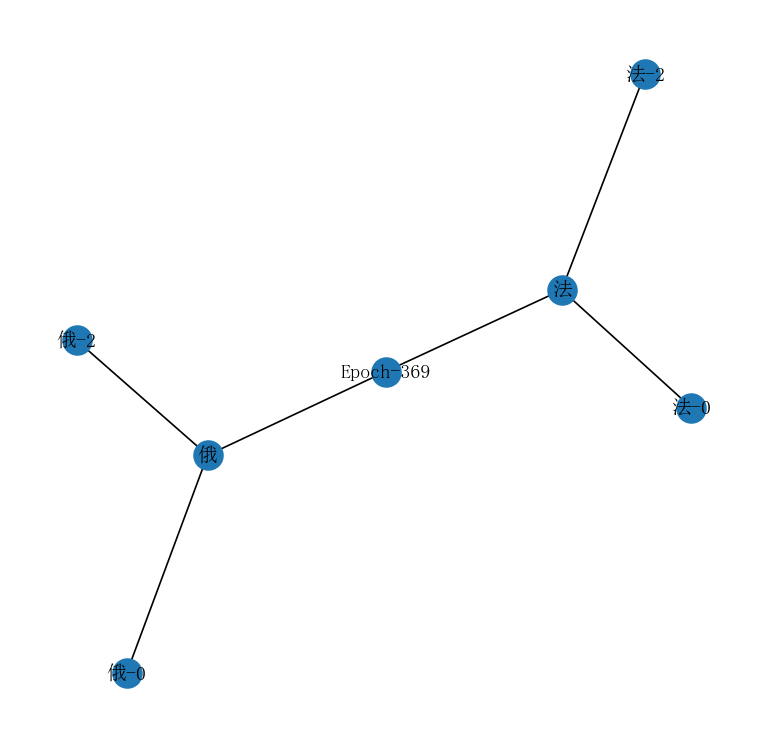

In [45]:
#列印特定epoch的圖
worker.plot_graph(worker.get_epoch_graph(369))

In [46]:
worker.get_game_history_by_grpah(game_networks[3])

俄-0 ( 9,  2): 6
俄-1 ( 4, 15): 1
俄-2 ( 5, 18): 1
德-0 (17,  5): 1
德-2 ( 3,  9): 1
德-4 (18,  2): 1
法-0 ( 2, 10): 2
法-2 (11, 11): 2
